# 미국장과 한국장 연관성

데이트레이더 오버나잇 안하는 이유. S&P500 지수와 코스피 지수. 
미국장 떨어지면 한국장도 떨어진다고 함. 진짜 그런지. 만약 연관성이 있다면 수익을 낼 수 있으.ㅁ 

먼저 pandas_datareader로 데이터를 받아온다. 코스피 지수, S&P500 지수 대신 'KODEX200', 'SPDR S&P 500 ETF Trust' ETF를 사용했다. 백테스팅 기간은 2010년도부터. 
짜증나는 점은 이유는 모르겠으나 yahoo에서 데이터를 가져오면 동일날짜 데이터가 두 개 있는 경우가 있다. 
비교를 위해 일별등락률을 계산해서 추가한다. 

<AxesSubplot:title={'center':'SPY'}, xlabel='Date'>

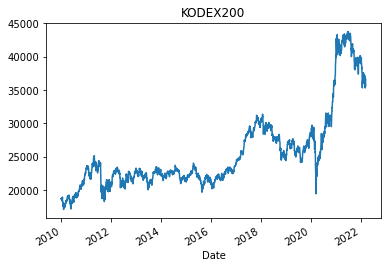

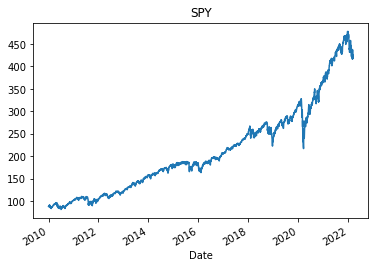

In [19]:
from pandas_datareader import data as web
import matplotlib.pyplot as plt

# KODEX 200
kdx = web.DataReader('069500', 'naver', start='2010-01-01')
kdx['Close'] = kdx['Close'].astype(int) # 이유는 모르겠으나 주가가 문자열로 저장되어 있다.
kdx['ret'] = kdx['Close'].pct_change()
kdx['Close'].plot(title="KODEX200")
plt.figure()

# SPDR S&P 500 ETF Trust (SPY)
spy = web.DataReader('SPY', 'yahoo', start='2010-01-01')
# 프레임워크 오류로 마지막 날 동일날짜 데이터가 두 개 있는 경우가 있다. 
if spy.index[-1] == spy.index[-2]:
    spy = spy[:-1]
spy['ret'] = spy['Adj Close'].pct_change()
spy['Adj Close'].plot(title="SPY")


2010년도부터 현재까지 미국장과 한국장 그래프. 알다시피 미국장은 우상향하는데 한국장은 군데군데 박스권에 갇힌 모습이 보인다.  

# 일별수익률 커브 비교

일별 수익률 그래프를 비교해 본다.로그 수익률은 전일에 비해 몇 퍼센트 올랐는지만 비교하기 때문에 장기적인 그래프 모양과 상관없다. 

전체적인 데이터를 비교하기엔 양이 너무 많아 최근 100일만 확인해 보았지만, 워낙 들쭉날쭉에 딱히 패턴이 있는 것 같지 않다. 

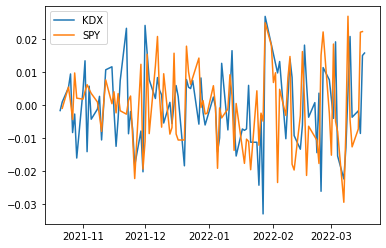

In [20]:
plt.figure()
plt.plot(kdx['ret'][-100:], label="KDX")
plt.plot(spy['ret'][-100:], label="SPY")
plt.legend()

미국장이 다음 날 한국장에 미치는 영향을 알고 싶다. 한국과 미국 증시 개장일이 다르기에 미국 개장일 바로 다음 한국 개장일이 아닌 경우는 제외한다. 그 사이에 무슨 이벤트가 생겨 연속성이 없어 질 수 있기에 제외하는 편이 낫다고 생각했다.

In [21]:
import datetime
import pandas as pd

nextOpenDayofS = (spy.index + datetime.timedelta(days=1)) & kdx.index
beforeOpenDayofK = spy.index  & (nextOpenDayofS - datetime.timedelta(days=1))
finalK = (beforeOpenDayofK + datetime.timedelta(days=1)) & nextOpenDayofS

nspy = spy[spy.index.isin(beforeOpenDayofK)]
nkdx = kdx[kdx.index.isin(finalK)]

len(nspy), len(nkdx)

/var/folders/tk/1dsltsc50rgfq9t3krytny280000gn/T/ipykernel_871/788358586.py:4: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  nextOpenDayofS = (spy.index + datetime.timedelta(days=1)) & kdx.index
/var/folders/tk/1dsltsc50rgfq9t3krytny280000gn/T/ipykernel_871/788358586.py:5: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  beforeOpenDayofK = spy.index  & (nextOpenDayofS - datetime.timedelta(days=1))
/var/folders/tk/1dsltsc50rgfq9t3krytny280000gn/T/ipykernel_871/788358586.py:6: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  finalK = (beforeOpenDayofK + datetime.timedelta(days=1)) 

(2322, 2322)

In [22]:
num_same = 0
num_diff = 0
for a, b in zip(nspy['ret'], nkdx['ret']):
    if (a>=0 and b>=0) or (a<=0 and b<=0):
        num_same += 1
    else:
        num_diff += 1

percentage = num_same / (num_same + num_diff) * 100
print(f"total samples: {num_diff+num_same}")
print(f"same trend: {num_same} times")
print(f"{percentage}%")

total samples: 2322
same trend: 1489 times
64.12575366063739%


한국장은 64% 확률로 미국장과 같은 방향으로 움직인다. 

혹시 몰라 기간을 2002년도부터(그 이전은 데이터가 없다.) 테스트해도 2305/3703, 62% 같은 방향으로 움직인다. 

그래도 확률이 반 이상이니 매번 매매하면 수익이 날까 생각이 들어도, 방향이 다를 때 크게 손실 나면 의미가 없다.

실제로 매매하면 어떻게 될지 벡테스팅을 해보겠다. 

In [74]:
for s, k in zip(nspy['ret'], nkdx['ret']):
    # print(f'{s} {k}')
    cumret = 1
    buyhold = 1
    # long if spy increases, short if spy decreases
    if s >= 0:
        cumret *= (1 + k)
    else:
        cumret *= (1 - k)
    
    buyhold *= (1 + k)

print(cumret)
print(buyhold)

1.015677025527192
1.015677025527192


In [ ]:
# 백테스팅. 미국장 바로 다음 날 한국장 열릴 경우에만 매매.
# from backtesting.test import GOOG
from backtesting import Strategy
from backtesting.lib import crossover

class SmaCross(Strategy):
    
    def init(self):
        pass
    
    def next(self):
        print(self.data.index[-1])
        print(type(self.data["Close"][-1]))

        self.buy()

        self.sell()

from backtesting import Backtest

bt = Backtest(nkdx, SmaCross, cash=100_0000, commission=.002)
stats = bt.run()
stats
bt.plot() 